## CNN on 15-scene dataset

Download the data from assignment 2.. This had a train and test directory. Each folder has 15 sub-folders corresponding to each category.

**IMPORTANT**: After you have copied the dataset, swap the names of the train and test folder, i.e., the default train folder should be test, and the other is train (the default test folder contains more images, and we want to make sure you have more images for training).

In [4]:
import numpy as np
import skimage
from skimage import io, img_as_float
from skimage.transform import resize

import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
from random import shuffle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50


import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math




### Helper functions to load images

In [5]:
def load_image_gray(path, output_shape):    
    img = io.imread(path) 
    
    image_resized = resize(img, output_shape, anti_aliasing=True)

    image_resized = (255 * np.array(image_resized)).astype(np.uint8)
    
    
    return image_resized
    

In [6]:
def get_image_arrays(data_path, categories, output_shape, fmt='jpg'):
    """
    This function returns lists containing the np array for each train
    and test image, as well as listss with the label of each train and
    test image. By default all four of these arrays will have 1500
    elements where each element is a string.
    :param data_path: path to the 'test' and 'train' directories
    :param categories: list of category names
    :param fmt: file extension of the images
    :return: lists: train_image_arrays, test_image_arrays, train_labels, test_labels
    """
    train_image_paths = []
    test_image_paths = []
    train_labels = []
    test_labels = []

    for i, cat in enumerate(categories):
        # train
        pth = osp.join(data_path, 'train', cat, '*.{:s}'.format(fmt))
        print(pth)
        pth = glob(pth)

        train_image_paths.extend(pth)
        train_labels.extend([i] * len(pth))

        # test
        pth = osp.join(data_path, 'validation', cat, '*.{:s}'.format(fmt))
        print(pth)
        pth = glob(pth)

        test_image_paths.extend(pth)
        test_labels.extend([i] * len(pth))

    train_image_arrays = [load_image_gray(p, output_shape) for p in train_image_paths]
    test_image_arrays = [load_image_gray(p, output_shape) for p in test_image_paths]

    return train_image_arrays, test_image_arrays, train_labels, test_labels

In [7]:
# This is the list of categories / directories to use. The categories are
# somewhat sorted by similarity so that the confusion matrix looks more
# structured (indoor and then urban and then rural).
categories = ['female', 'male'];
# This list of shortened category names is used later for visualization
abbr_categories = ['F', 'M'];

**TODO**: RESIZE AS PER THE REQUIREMENT OF THE SIMPLE NET BELOW (DO NOT SCALE back to 255, do not convert to uint8)

In [8]:
#### GRADED CELL ####

#Enter code here to resize your images as per the requirements of the SimpleNet (what's the input dimension?)
#Call the function get_image_arrays with correct output_shape and then convert to numpy array
#Store the final images in train_image_arrays and test_image_arrays (both numpy arrays)
#Store the final labels in train_labels and test_labels (both numpy arrays)

#YOUR CODE 


output_shape = (180, 320)
data_path = osp.join('.', 'data')

train_image_arrays, test_image_arrays, train_labels, test_labels = get_image_arrays(data_path,
                                                                                 categories,
                                                                                output_shape
                                                                               )
train_image_arrays = np.array(train_image_arrays)
test_image_arrays = np.array(test_image_arrays)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)




.\data\train\female\*.jpg
.\data\validation\female\*.jpg
.\data\train\male\*.jpg
.\data\validation\male\*.jpg


In [9]:
print(train_image_arrays.shape) #CONFIRM that output is (2985, 64, 64, 3)
print(test_image_arrays.shape) #CONFIRM that output is (1500, 64, 64, 3)

(4000, 180, 320, 3)
(1000, 180, 320, 3)


In [10]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_simple_model(input_shape):
    """
    This function should build a Sequential model according to the above specification. Ensure the 
    weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument.
    Your function should also compile the model with the Adam optimiser, a cross
    entropy loss function (which one? categorical or sparse categorical?), and a single accuracy metric.
    """
    model_resnet = VGG19(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

    layers_to_freeze = 19

    for layer in model_resnet.layers[:layers_to_freeze]:
        layer.trainable = False

    for layer in model_resnet.layers[layers_to_freeze:]:
        layer.trainable = True

    model_tl = Sequential([
                        model_resnet,
                        Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
                        Dense(2, activation='softmax', kernel_regularizer = tf.keras.regularizers.l2(0.1))
                        ])


    model_tl.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
        metrics = ['accuracy']
        )  

    return model_tl
    


#### Compile and evaluate the model

In [11]:
desired_input_shape = train_image_arrays[0].shape
print(desired_input_shape)

model = get_simple_model(desired_input_shape)
print(len(model.trainable_variables))
#Print the model summary 
model.summary()

(180, 320, 3)
8
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 20,288,066
Trainable params: 4,983,298
Non-trainable params: 15,304,768
_________________________________________________________________


In [12]:
def get_preprocessed_input():
    '''
    Pre-processes the 15-SCENE data using Resnet50 preprocessing function.
    
    Returns the tupple of pre-processed training and test data.
    '''
    ### BEGIN SOLUTION
    x_train_resnet = tf.keras.applications.vgg19.preprocess_input(train_image_arrays)
    x_test_resnet = tf.keras.applications.vgg19.preprocess_input(test_image_arrays)

    print(x_train_resnet.shape)
    print(x_test_resnet.shape)
    
    return (x_train_resnet, x_test_resnet)
    ### END SOLUTION

In [13]:
train_image_resnet, test_image_resnet = get_preprocessed_input()

(4000, 180, 320, 3)
(1000, 180, 320, 3)


In [14]:
# Run this cell to define a function to evaluate a model's test accuracy

def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    return test_acc

In [15]:
# Calculate its initial test accuracy (without any training)

test_init = get_test_accuracy(model, test_image_arrays, test_labels)

accuracy: 0.405


In [16]:
# Train model using the callbacks you just created
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 3, mode = 'max', verbose = 1)

#callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
history = model.fit(train_image_arrays, train_labels, epochs=30, validation_data=(test_image_arrays, test_labels), callbacks=[early_stopping]) #, callbacks=callbacks


Epoch 1/30
125/125 [==============================] - 13s 96ms/step - loss: 43.1055 - accuracy: 0.8478 - val_loss: 34.4446 - val_accuracy: 0.9430
Epoch 2/30
125/125 [==============================] - 11s 87ms/step - loss: 27.9184 - accuracy: 0.9498 - val_loss: 22.1234 - val_accuracy: 0.9410
Epoch 3/30
125/125 [==============================] - 11s 87ms/step - loss: 17.7351 - accuracy: 0.9697 - val_loss: 13.9872 - val_accuracy: 0.9410
Epoch 4/30
125/125 [==============================] - 11s 87ms/step - loss: 11.1154 - accuracy: 0.9830 - val_loss: 8.7496 - val_accuracy: 0.9560
Epoch 5/30
125/125 [==============================] - 11s 87ms/step - loss: 6.9049 - accuracy: 0.9918 - val_loss: 5.4894 - val_accuracy: 0.9560
Epoch 6/30
125/125 [==============================] - 12s 96ms/step - loss: 4.3117 - accuracy: 0.9912 - val_loss: 3.4889 - val_accuracy: 0.9620
Epoch 7/30
125/125 [==============================] - 12s 95ms/step - loss: 2.7143 - accuracy: 0.9980 - val_loss: 2.2810 - val_ac

In [17]:
#Define functions to plot accuracy and loss
def plotAccuracy(history):

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 
    
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 

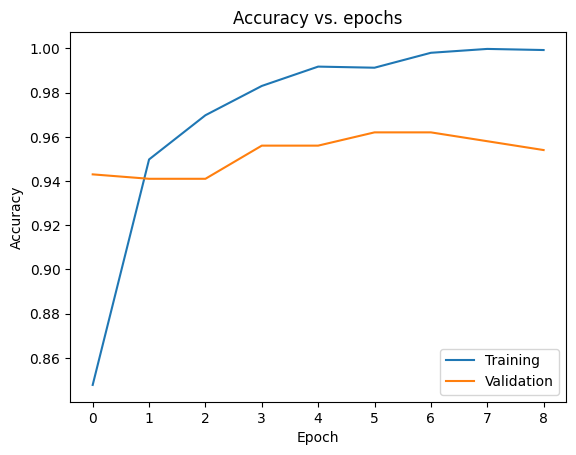

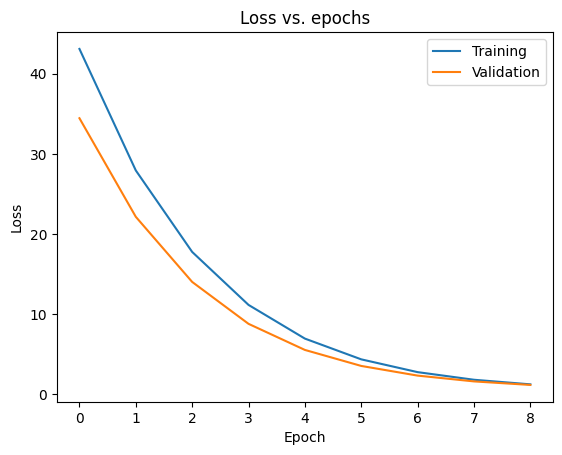

In [18]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(history)
plotLoss(history)


In [19]:
test_first = get_test_accuracy(model, test_image_arrays, test_labels)
#NOTE: You should receive at least 50% accuracy in this step. This will go in the REPORT.

accuracy: 0.954


In [20]:
# Function to Plot confusion matrix

def confMat(model, x_test, y_test):
    plt.figure(figsize=(15, 5))

    #Predict test images
    predict_x = model.predict(x_test)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=categories, columns=categories)

    plt.title("Confusion matrix\n")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.show()

32/32 [==============================] - 2s 74ms/step


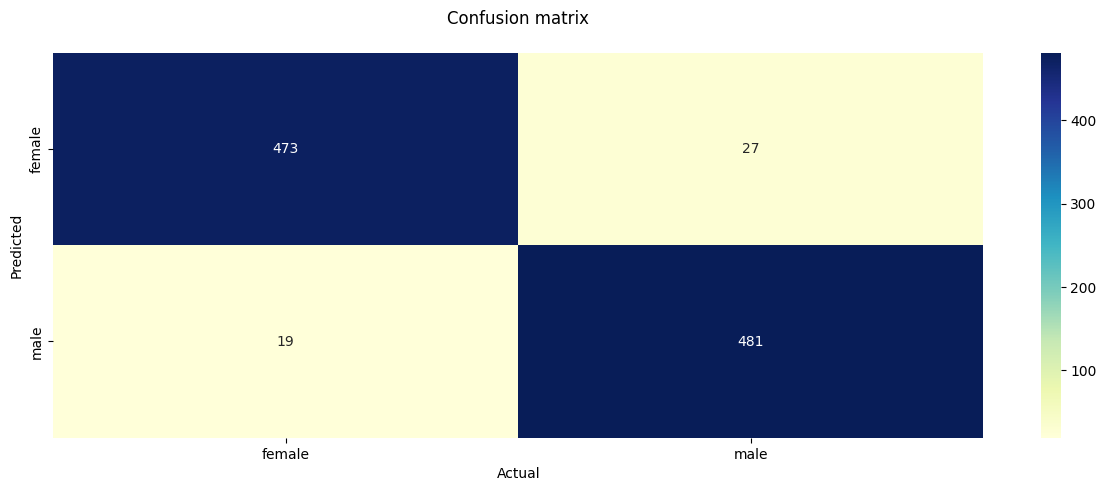

In [21]:
# Plot confusion matrices for model
confMat(model,test_image_arrays, test_labels)
#This will go in the REPORT.

In [22]:
import face_recognition
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

In [39]:
image1 = image.load_img("./data/Validation_long/female/113241.jpg.jpg", target_size = (180, 320))

transformedImage = image.img_to_array(image1)
transformedImage = np.expand_dims(transformedImage, axis = 0)
transformedImage = preprocess_input(transformedImage)

prediction = model.predict(transformedImage)
if prediction[0][0] > prediction[0][1]:
    print('female')

1/1 [==============================] - 0s 23ms/step
female


In [43]:
video_capture = cv2.VideoCapture(0)



# Initialize some variables
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True
predictionLabel = ''

while True:
    ret, frame = video_capture.read()

    if process_this_frame:
        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)

        rgb_small_frame = small_frame[:, :, ::-1]
        
        ###
        transformedImage = image.img_to_array(rgb_small_frame)
        transformedImage = np.expand_dims(transformedImage, axis = 0)
        transformedImage = preprocess_input(transformedImage)

        prediction = model.predict(transformedImage)

        if prediction[0][0] > prediction[0][1]:
            predictionLabel = f'female{prediction[0][0]}'
        else:
            predictionLabel= f'male{prediction[0][1]}'

        ###

        face_locations = face_recognition.face_locations(rgb_small_frame)

    #process_this_frame = not process_this_frame


    for (top, right, bottom, left) in face_locations:
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        cv2.rectangle(frame, (left - 10, top - 50), (right + 10, bottom + 50), (0, 0, 255), 2)
        cv2.rectangle(frame, (left-11, bottom + 50), (right + 11, bottom + 75), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, predictionLabel, (left - 6, bottom + 65), font, 0.5, (255, 255, 255), 1)

    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step
